<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/needs_scan_panel/needs_RSCCMM_CF_cluster_membership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv
import openpyxl as op

In [12]:
import pandas as pd
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs.shape)
print(test_needs)

(996, 18)
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


In [3]:
import numpy as np
import sys
import random

#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u, w

In [13]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  delta_max = 0
  every_cluster_objs_max = 0
  n_overlaps_max = 0
  w_max = 0
  output = []

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rough_u, w = RSCCMM(X, C, delta) # RSCCM法を適用
    every_cluster_objs = np.sum(rough_u, axis=1) # 各クラスターの要素数
    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64)) # オーバーラップした要素数

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算
    output.append([auc, ', '.join(map(str, every_cluster_objs)), n_overlaps, X.shape[0] - n_overlaps])

    if auc > auc_max:
      auc_max = auc
      w_max = w
      delta_max = delta
      every_cluster_objs_max = every_cluster_objs
      n_overlaps_max = n_overlaps


  return auc_max, every_cluster_objs_max, n_overlaps_max, w_max, output

print(RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, 100, -7))

(0.85113421157552, array([514., 488., 292., 240., 312., 362., 182., 199., 108., 429., 190.,
       717., 736., 473., 107., 542., 473., 337., 168., 440., 354.,  64.,
       485., 512., 417., 217., 242., 415., 504., 323., 760., 450.,  64.,
       658.,  64., 376.,  64.,  64., 491., 458., 373., 566.,  48., 159.,
       493., 183., 512., 174., 502., 568., 188., 597., 239., 275., 367.,
       237., 357., 478., 675., 752., 609., 445., 346., 340., 281., 310.,
       449., 238., 416., 407., 472.,  27., 246., 415., 614., 703., 337.,
       203.,  98., 147.,  64.,  64., 107., 302., 201., 305., 333., 503.,
       628., 263., 223., 428.,  49., 439., 303., 375., 677., 107., 566.,
       551.]), 957.0, array([[0.06638434, 0.03537262, 0.08058963, ..., 0.0951655 , 0.01892697,
        0.04786377],
       [0.06713703, 0.03114933, 0.08993013, ..., 0.08861389, 0.01715268,
        0.0194394 ],
       [0.08186657, 0.06381191, 0.08445072, ..., 0.08387384, 0.01767993,
        0.02079728],
       ...,
       [

[['AUC', '各クラスターの要素数', 'オーバーラップしている要素の数', 'オーバーラップしていない要素の数'], [0.8461089607282876, '440.0, 406.0, 34.0, 404.0, 719.0, 622.0, 374.0, 473.0, 210.0, 188.0, 474.0, 360.0, 150.0, 166.0, 503.0, 736.0, 550.0, 34.0, 34.0, 34.0, 337.0, 305.0, 229.0, 207.0, 515.0, 355.0, 383.0, 233.0, 129.0, 222.0, 335.0, 763.0, 438.0, 68.0, 295.0, 494.0, 217.0, 196.0, 34.0, 434.0, 183.0, 47.0, 405.0, 574.0, 13.0, 214.0, 614.0, 223.0, 354.0, 724.0, 250.0, 294.0, 317.0, 272.0, 404.0, 592.0, 360.0, 420.0, 445.0, 377.0, 662.0, 34.0, 760.0, 597.0, 277.0, 529.0, 34.0, 105.0, 308.0, 34.0, 536.0, 69.0, 480.0, 454.0, 474.0, 425.0, 203.0, 60.0, 68.0, 312.0, 578.0, 645.0, 124.0, 300.0, 587.0, 34.0, 413.0, 449.0, 736.0, 123.0, 456.0, 370.0, 438.0, 109.0, 226.0, 510.0, 266.0, 187.0, 307.0, 232.0', 960.0, 36.0]]


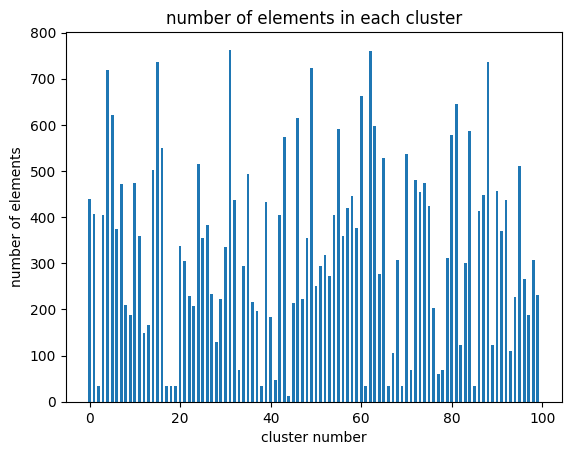

In [15]:
# 可視化
name = "needs_RSCCMM_cluster"
C = 100
auc_max, every_cluster_objs_max, n_overlaps_max, w_max, output = RSCCMM_CF_AUC_CLUSTER(1, test_needs, X_needs, C, -7)

plt.bar(range(C), every_cluster_objs_max, width=0.6)

# plt.legend()
plt.title('number of elements in each cluster')
plt.xlabel('cluster number')
plt.ylabel('number of elements')
plt.savefig(f"{name}.png", format="png", dpi=300)

csv_output = [["AUC", "各クラスターの要素数", "オーバーラップしている要素の数", "オーバーラップしていない要素の数"]]
for row in output:
  csv_output.append(row)
print(csv_output)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(csv_output)

In [ ]:
対象別で所属しているクラスターの数